Import the data from database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# connect to sqlite3 database

# Replace with your database file path in Google Drive
db_path = 'my_database.db'

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

df_encoded = pd.read_sql("SELECT * FROM Interest_Rate_Features", conn)
# Example query (replace with your actual query)
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

conn.close()

[('raw_data',), ('Loan_Approval',), ('Interest_Rate_Features',), ('Property_Values',), ('Risk_classifier',)]


In [3]:
df_encoded.columns

Index(['interest_rate', 'loan_amount', 'loan_term', 'loan_purpose_2',
       'loan_purpose_4', 'loan_purpose_5', 'loan_type_2', 'loan_type_3',
       'lien_status_2', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features',
       'conforming_loan_limit_NC',
       'derived_loan_product_type_Conventional:Subordinate Lien',
       'derived_loan_product_type_FHA:First Lien',
       'derived_loan_product_type_VA:First Lien',
       'derived_loan_product_type_VA:Subordinate Lien',
       'applicant_credit_score_type', 'co-applicant_credit_score_type',
       'co-applicant_age', 'applicant_age_above_62', 'occupancy_type_3',
       'manufactured_home_secured_property_type_2',
       'manufactured_home_land_property_interest_3',
       'submission_of_application_3', 'initially_payable_to_institution_3',
       'purchaser_type', 'business_or_commercial_purpose',
       'open-end_line_of_credit', 'reverse_mortgage'],
      dtype='object')

Model

In [5]:
# Load dataset
df = df_encoded.copy()

# Define target and predictors
target = 'interest_rate'
predictors = df.columns[df.columns != target]

X = df[predictors]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# XGBoost Regressor Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.3, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R^2 Score: {r2_score(y_true, y_pred)}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")


Linear Regression Performance:
MAE: 0.8810998201618054
MSE: 1.7514670607722302
RMSE: 1.3234300362211182
R^2 Score: 0.2915795886439707

XGBoost Regressor Performance:
MAE: 0.7372681813053902
MSE: 1.080985630789137
RMSE: 1.0397045882312614
R^2 Score: 0.5627709464910201



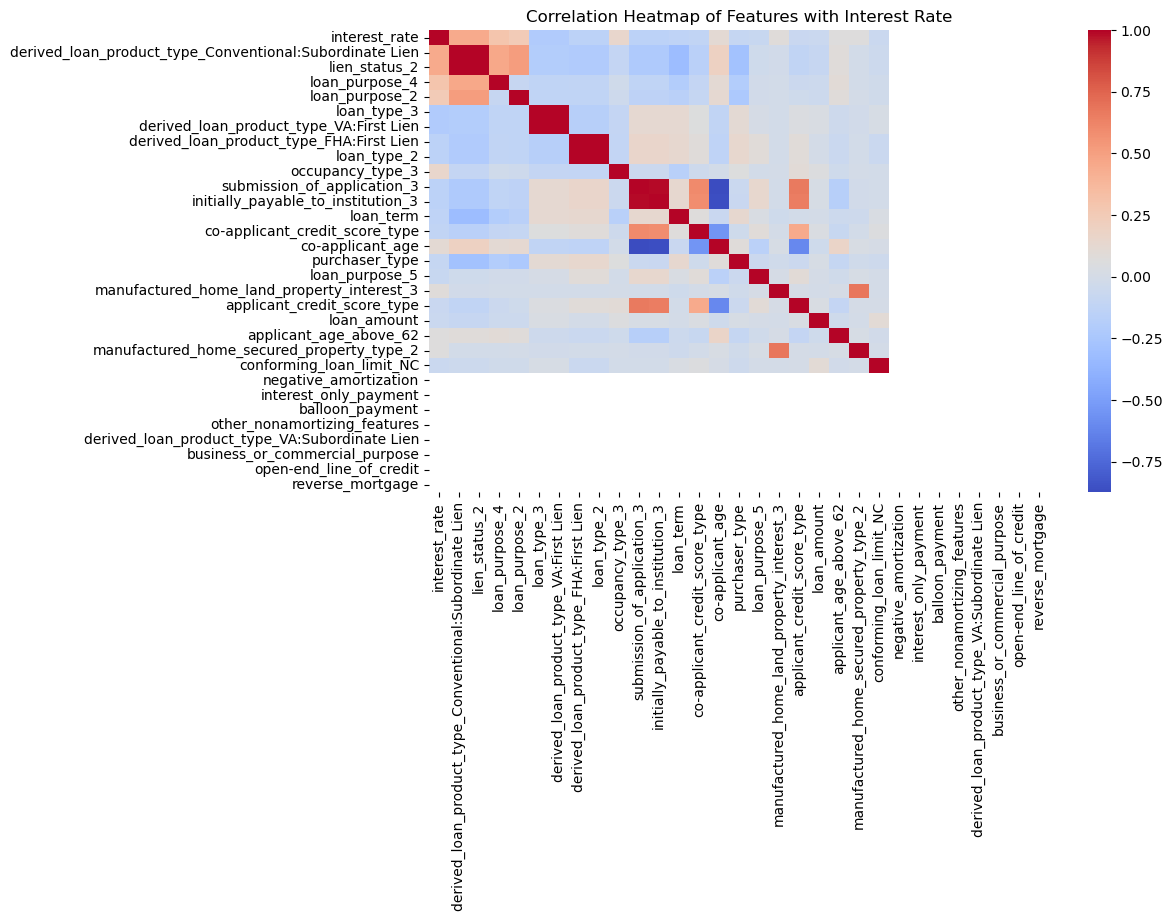

In [6]:
# Compute correlation with interest_rate
correlation = df_encoded.corr()['interest_rate'].abs().sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded[correlation.index].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features with Interest Rate")
plt.show()

# Display highly correlated features
correlation[1:15]  # Exclude interest_rate itself

# Drop low-correlation columns
low_corr_features = correlation[correlation < 0.05].index
df_reduced = df_encoded.drop(columns=low_corr_features)


In [12]:
import joblib
joblib.dump(xgb_model, 'interest_rate_model.pkl')

['interest_rate_model.pkl']

In [11]:
df_encoded.describe()

,interest_rate,loan_amount,loan_term,loan_purpose_2,loan_purpose_4,loan_purpose_5,loan_type_2,loan_type_3,lien_status_2,negative_amortization,...,applicant_age_above_62,occupancy_type_3,manufactured_home_secured_property_type_2,manufactured_home_land_property_interest_3,submission_of_application_3,initially_payable_to_institution_3,purchaser_type,business_or_commercial_purpose,open-end_line_of_credit,reverse_mortgage
count,340510.000000,3.405100e+05,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.0,...,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.000000,340510.0,340510.0,340510.0
mean,6.981102,3.496741e+05,336.035893,0.083319,0.081983,0.004896,0.160207,0.142510,0.192893,0.0,...,0.128592,0.059349,0.003571,0.001648,0.192359,0.195874,2.501668,0.0,0.0,0.0
std,1.565336,1.350062e+06,74.679488,0.276364,0.274339,0.069797,0.366798,0.349573,0.394570,0.0,...,0.334749,0.236277,0.059652,0.040556,0.394154,0.396872,2.941354,0.0,0.0,0.0
min,0.000000,5.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,6.125000,1.550000e+05,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,6.750000,2.850000e+05,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0
75%,7.500000,4.250000e+05,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.0,0.0,0.0
max,19.625000,2.543750e+08,827.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,0.0,0.0,0.0
